# Random opeartions on Image Dataset

In [1]:
# This script applies random operations to all images in an input directory and saves the results in an output directory.
# The images are cropped and resized to 200x200 pixels and then compressed using JPEG at a random quality level.
#
# Usage:
#    python random_operations.py <input directory> <output directory> <seed>
#
# Libraries:
#    pillow=9.0.1
#    jpeg=9e
#    tqdm=4.63.0
#


import os
from PIL import Image
import tqdm
import shutil
import glob
from random import Random

import cv2
import numpy as np

output_size  = 200
cropsize_min = 160
cropsize_max = 2048
cropsize_ratio = (5,8)
qf_range = (65, 100)

def check_img(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.gif'))

def random_operations(input_dir, output_dir, seed, maximg=None):
    print('Random Operations from ', input_dir, 'to', output_dir, flush=True)
    if os.path.isdir(output_dir):
        shutil.rmtree(output_dir)  # remove existing output directory
    os.makedirs(output_dir)  # create output directory
    
    random = Random(seed) # set seed 
    
    # list fo images
    input_dir = input_dir if '*' in input_dir else os.path.join(input_dir, '*')
    list_src = [_ for _ in sorted(glob.glob(input_dir)) if check_img(_)]
    
    if maximg is not None:
        random.shuffle(list_src)  # shuffle the list of images
        list_src = list_src[:maximg]  # limit the number of images
    
    with open(os.path.join(output_dir, 'metainfo.csv'), 'w') as fid:
        fid.write('filename,src,cropsize,x1,y1,qf\n')
        for index, src in enumerate(tqdm.tqdm(list_src)):
            filename_dst = 'img%06d.jpg' % index
            dst = os.path.join(output_dir, filename_dst)
            
            # open image
            img = Image.open(src).convert('RGB')
            height = img.size[1]
            width = img.size[0]

            # select the size of crop
            cropmax = min(min(width, height), cropsize_max)
            if cropmax<cropsize_min:
                print(src, width, height)
            assert cropmax>=cropsize_min
            
            cropmin = max(cropmax*cropsize_ratio[0]//cropsize_ratio[1], cropsize_min)
            cropsize = random.randint(cropmin, cropmax)
            
            # select the type of interpolation
            interp = Image.ANTIALIAS if cropsize>output_size else Image.CUBIC
            
            # select the position of the crop
            x1 = random.randint(0, width - cropsize)
            y1 = random.randint(0, height - cropsize)
            
            # select the jpeg quality factor
            qf = random.randint(*qf_range)
            
            # make cropping
            img = img.crop((x1, y1, x1+cropsize, y1+cropsize))
            assert img.size[0]==cropsize
            assert img.size[1]==cropsize
            
            # make resizing
            img = img.resize((output_size, output_size), interp)
            assert img.size[0]==output_size
            assert img.size[1]==output_size
            
            # make jpeg compression
            img.save(dst, "JPEG", quality = qf)
            
            # save information
            fid.write(f'{filename_dst},{src},{cropsize},{x1},{y1},{qf}\n')
            
            
if __name__=='__main__':
    from sys import argv
    #input_dir  = argv[1]
    #output_dir = argv[2]
    #seed       = int(argv[3])
    #maximg     = int(argv[4]) if len(argv)>4 else None
    random_operations(r'F:\ENTC\VIP_CUP_2022\data\real', r'F:\ENTC\VIP_CUP_2022\data\real\real_preprossed', 17 )
    random_operations(r'F:\ENTC\VIP_CUP_2022\data\fake', r'F:\ENTC\VIP_CUP_2022\data\fake\fake_preprossed', 17 )
    

Random Operations from  F:\ENTC\VIP_CUP_2022\data\real to F:\ENTC\VIP_CUP_2022\data\real\real_preprossed


100%|██████████| 26000/26000 [46:08<00:00,  9.39it/s]

Random Operations from  F:\ENTC\VIP_CUP_2022\data\fake to F:\ENTC\VIP_CUP_2022\data\fake\fake_preprossed



100%|██████████| 26000/26000 [09:16<00:00, 46.71it/s]


In [ ]:
pip install split-folders

In [6]:
import splitfolders
splitfolders.ratio(  r'F:\ENTC\VIP_CUP_2022\data\data_preprocessed', output=r'F:\ENTC\VIP_CUP_2022\data\data_split' , seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 52000 files [25:55, 33.42 files/s]


# Image patch generation 

In [ ]:
from utils.python_patch_extractor.PatchExtractor import PatchExtractor
import cv2
import numpy as np
import os
import random

def patch_images_genrate(img_folder_path,patch_img_file):

    image_path_list = [os.path.join(img_folder_path, 'img{:06}.jpg'.format(x)) for x in range(26001)]
    print(image_path_list[0])

    for j,img_ in enumerate(image_path_list):
        img1 = cv2.imread(img_)
        if img1 is None:
            pass
        else:
            img2 = cv2.resize(img1, (200, 200))    
            img = np.asarray(img2)
                
            stride_0 = ((((img.shape[0] - 32) // 20) + 7) // 8) * 8
            stride_1 = (((img.shape[1] - 32) // 10 + 7) // 8) * 8
            pe = PatchExtractor(dim=(32, 32, 3), stride=(stride_0, stride_1, 3))
            patches = pe.extract(img)
            patch_list = list(patches.reshape((patches.shape[0] * patches.shape[1], 32, 32, 3)))
             
             #change patch no according to your code
            patch_rand = random.sample(patch_list, 2)
            for i, patch_img in enumerate(patch_rand):
                cv2.imwrite(os.path.join(patch_img_file,'img{:06}_{:06}.jpg'.format(j,i)), patch_img)
    return(None)

In [17]:
img_folder_path_train_r =r'F:\ENTC\VIP_CUP_2022\data\data_split\train\real_preprossed'
patch_img_file_train_r =r'F:\ENTC\VIP_CUP_2022\data\patch_data\train\real'
img_folder_path_train_s =r'F:\ENTC\VIP_CUP_2022\data\data_split\train\fake_preprossed'
patch_img_file_train_s = r'F:\ENTC\VIP_CUP_2022\data\patch_data\train\fake'

patch_images_genrate(img_folder_path_train_r,patch_img_file_train_r)
patch_images_genrate(img_folder_path_train_s,patch_img_file_train_s)

img_folder_path_val_r =r'F:\ENTC\VIP_CUP_2022\data\data_split\val\real_preprossed'
patch_img_file_val_r = r'F:\ENTC\VIP_CUP_2022\data\patch_data\val\real'
img_folder_path_val_s =r'F:\ENTC\VIP_CUP_2022\data\data_split\val\fake_preprossed'
patch_img_file_val_s = r'F:\ENTC\VIP_CUP_2022\data\patch_data\val\fake'

patch_images_genrate(img_folder_path_val_r,patch_img_file_val_r)
patch_images_genrate(img_folder_path_val_s,patch_img_file_val_s)

img_folder_path_test_r =r'F:\ENTC\VIP_CUP_2022\data\data_split\test\real_preprossed'
patch_img_file_test_r = r'F:\ENTC\VIP_CUP_2022\data\patch_data\test\real'
img_folder_path_test_s =r'F:\ENTC\VIP_CUP_2022\data\data_split\test\fake_preprossed'
patch_img_file_test_s = r'F:\ENTC\VIP_CUP_2022\data\patch_data\test\fake'

patch_images_genrate(img_folder_path_test_r,patch_img_file_test_r)
patch_images_genrate(img_folder_path_test_s,patch_img_file_test_s )

F:\ENTC\VIP_CUP_2022\data\data_split\train\real_preprossed\img000000.jpg
F:\ENTC\VIP_CUP_2022\data\data_split\train\fake_preprossed\img000000.jpg
F:\ENTC\VIP_CUP_2022\data\data_split\val\real_preprossed\img000000.jpg
F:\ENTC\VIP_CUP_2022\data\data_split\val\fake_preprossed\img000000.jpg
F:\ENTC\VIP_CUP_2022\data\data_split\test\real_preprossed\img000000.jpg
F:\ENTC\VIP_CUP_2022\data\data_split\test\fake_preprossed\img000000.jpg


# Data Augmentation and Normalization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

In [ ]:


# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'train': transforms.Compose([
        
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = r'C:\Users\heeth\Desktop\GAN-image-detection-main\GAN-image-detection-main\patch_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model Building and Training 

Epoch 1/2
----------


c:\Users\heeth\miniconda3\envs\BM_1751\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6699 Acc: 0.5974
val Loss: 0.7816 Acc: 0.6232

Epoch 2/2
----------
train Loss: 0.6462 Acc: 0.6158
val Loss: 0.6203 Acc: 0.6501

Training complete in 20m 9s
Best val Acc: 0.650055


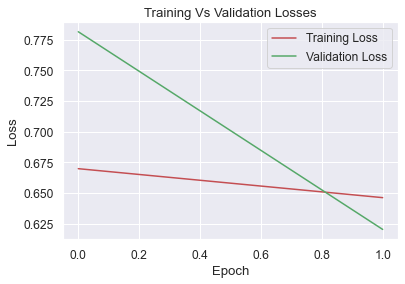

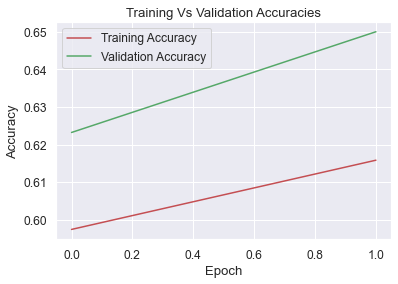

Accuracy of the network on the test images: 63 %
Accuracy of  real : 46 %
Accuracy of synthatic : 75 %
[[3104 3562]
 [2446 7454]]


<AxesSubplot:>

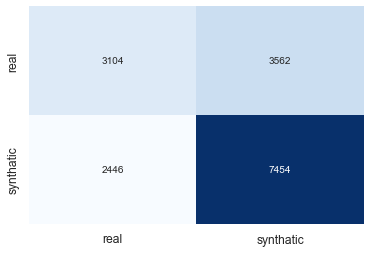

In [4]:


#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing        
            if phase == "train":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "val":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#Using a model pre-trained on ImageNet and replacing it's final linear layer

#For resnet18
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#for VGG16_BN
#model_ft = models.vgg16_bn(pretrained=True)
#model_ft.classifier[6].out_features = 8

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)       


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)        




#Plot the train & validation losses


plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()




#Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train,torch.tensor(train_acc).cpu().numpy(),color = 'r', label="Training Accuracy")
plt.plot(epoch_counter_val,torch.tensor(val_acc).cpu().numpy(),color = 'g', label="Validation Accuracy")
plt.legend()
plt.show()




#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

#Class wise testing accuracy
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(2)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 

torch.save(model_ft, 'mosel_stgan3_renet50.pth')

# Model prediction

In [2]:
from utils.python_patch_extractor.PatchExtractor import PatchExtractor
import cv2
import numpy as np
import os
from PIL import Image

def predict_single(input,label, model):

    transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])
    img_net_scores=[]
    img =input
    stride_0 = ((((img.shape[0] - 32) // 20) + 7) // 8) * 8
    stride_1 = (((img.shape[1] - 32) // 10 + 7) // 8) * 8
    pe = PatchExtractor(dim=(32, 32, 3), stride=(stride_0, stride_1, 3))
    patches = pe.extract(img)
    patch_list = list(patches.reshape((patches.shape[0] * patches.shape[1], 32, 32, 3)))
    print(len(patch_list))

    transf_patch_list = [ transform_test(Image.fromarray(patch)) for patch in patch_list]
    transf_patch_tensor = torch.stack(transf_patch_list, dim=0)

    print(transf_patch_tensor.shape)

    input =  transf_patch_tensor.to(device)

   

    patch_scores = model(input).cpu().detach().numpy()
    print(patch_scores)
   
    patch_predictions = np.argmax(patch_scores, axis=1)
  

    maj_voting = np.any(patch_predictions).astype(int)
    scores_maj_voting = patch_scores[:, maj_voting]
    img_net_scores.append(np.mean(scores_maj_voting) if maj_voting == 1 else -np.mean(scores_maj_voting))
    img_score = np.mean(img_net_scores)
    print(img_score)



 

In [3]:
from torchvision.datasets import ImageFolder
pred_ds = ImageFolder(r'C:\Users\heeth\Desktop\GAN-image-detection-main\GAN-image-detection-main\data_split\test\prediction_test')
np.array(pred_ds[0][0]).shape
predict_single(np.array(pred_ds[0][0]),0, model_ft)



242
torch.Size([242, 3, 32, 32])
[[ 1.44206472e-02  9.99619365e-01]
 [-6.54719710e-01  3.24033165e+00]
 [ 9.02139902e-01  8.50420094e+00]
 [ 1.86271524e+00  1.23840876e+01]
 [ 3.52118659e+00  7.59558487e+00]
 [ 3.90106589e-01  3.66294527e+00]
 [-3.23288977e-01  3.46666360e+00]
 [ 1.19761527e-01  7.85710454e-01]
 [-4.83522564e-01  6.91012383e-01]
 [-8.44735503e-02  6.68475628e-01]
 [ 1.17991403e-01  9.19853330e-01]
 [ 2.59828456e-02  9.93628621e-01]
 [-5.23825049e-01  4.30005503e+00]
 [ 5.55178404e+00  1.76271572e+01]
 [ 3.93215835e-01  4.30786514e+00]
 [ 4.03350562e-01  1.58265626e+00]
 [ 2.30501309e-01  8.75754595e-01]
 [ 3.01898688e-01  7.83629775e-01]
 [ 2.61970818e-01  7.54906058e-01]
 [-8.47276151e-02  8.64507377e-01]
 [-5.00816524e-01  2.58671880e+00]
 [ 1.41413435e-01  8.97915125e-01]
 [ 3.02652456e-02  9.96829748e-01]
 [-1.20424062e-01  9.40356541e+00]
 [ 8.13706589e+00  2.23000011e+01]
 [ 2.80149788e-01  1.77764571e+00]
 [ 3.03131163e-01  1.05649221e+00]
 [ 2.82478154e-01  8.4